In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import dataset and create two data frames: X containing only exposure amounts, y containing only the outcomes (1s and 0s)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/Artificial_Dataset_1.csv')

# Separate features and target
X = df.drop(columns=['Individual', 'AMLoutcome']).values  # Exposure columns only
y = df['AMLoutcome'].values  # Target variable (AML outcome), 1s and 0s

Define SMOTE and Undersampling Pipeline

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
# Define SMOTE and undersampler in a pipeline
smote = SMOTE(sampling_strategy=0.5)  # Create 0.5 synthetic samples for every real sample in AML-negative
undersample = RandomUnderSampler(sampling_strategy=0.8)  # Keep 80% of the AML-negative cases

pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

Apply the Pipeline to Resample Data

In [ ]:
# Apply transformations using pipeline defined above
X_resampled, y_resampled = pipeline.fit_resample(X, y)

Convert the data frames into PyTorch tensors, define data loader

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Convert resampled data to tensors for PyTorch
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.float32)

In [ ]:
# Define DataLoader with balanced data
dataset_resampled = TensorDataset(X_resampled, y_resampled)
data_loader = DataLoader(dataset_resampled, batch_size=32, shuffle=True)

Training Model with MSE Loss

In [ ]:
# Array of IUR values
IUR = np.array([3.03E-12, 1.25E-14, 1.09E-14, 2.24E-15, 1.25E-14, 1.34E-14, 1.68E-15, 4.33E-15])

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

Epoch 0, Loss: 0.09337501187547131
Epoch 100, Loss: 0.07660414762209847
Epoch 200, Loss: 0.07683212549651584
Epoch 300, Loss: 0.07861266520856043
Epoch 400, Loss: 0.08600069491117933
Epoch 500, Loss: 0.07719954677628285
Epoch 600, Loss: 0.08603470857835409
Epoch 700, Loss: 0.08667589814758113
Epoch 800, Loss: 0.07726345669614706
Epoch 900, Loss: 0.0778425178550717


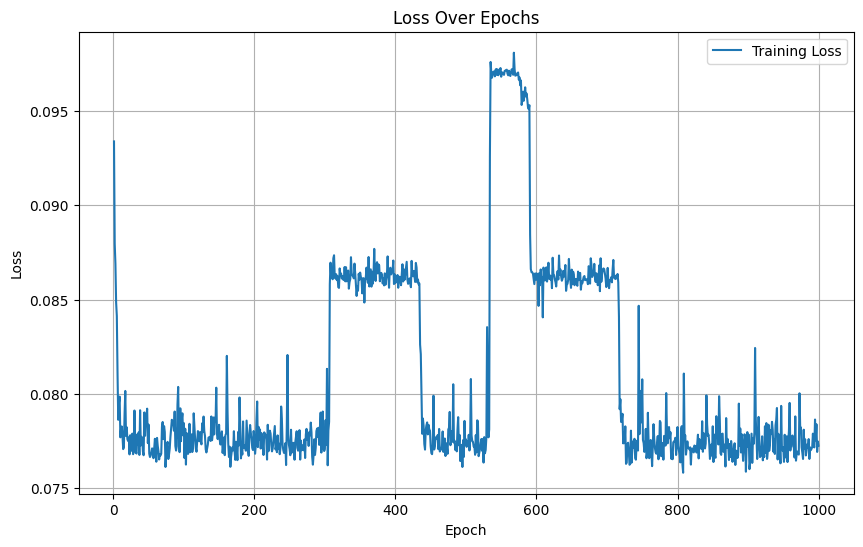

In [ ]:
# Initialize coefficients and exponents as trainable parameters
coefficients = torch.ones(8, requires_grad=True) # 8 because there are 8 substances
exponents = torch.ones(8, requires_grad=True)

# Define optimizer
optimizer = optim.Adam([coefficients, exponents], lr=0.01)

import matplotlib.pyplot as plt

# List to store loss values
loss_history = []

# Training loop
for epoch in range(1000):  # Number of epochs
    epoch_loss = 0  # Accumulate loss over batches in the epoch
    for batch_features, batch_targets in data_loader:
        # Calculate the risk based on current coefficients and exponents
        calculated_risk = sum(
            coefficients[i] * (IUR[i] * batch_features[:, i]) ** exponents[i] for i in range(8)
        )

        # Normalize the calculated risk by dividing each value by the maximum risk in the batch
        max_risk = calculated_risk.max()  # Find the maximum value in the batch
        normalized_risk = calculated_risk / max_risk  # Divide each risk by the max to normalize to [0, 1]

        # Calculate MSE loss
        loss = F.mse_loss(normalized_risk, batch_targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(data_loader)
    loss_history.append(avg_epoch_loss)

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {avg_epoch_loss}')

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

Accessing Learned Parameters

In [ ]:
import pandas as pd

# List of substance names
substance_names = [
    "PAH (polycyclic aromatic hydrocarbon)", "1,3-Butadiene", "O-Xylene", "Benzene",
    "Toluene", "Styrene", "p-dichloro", "Chloroform"
]

# Extract values from tensors
coefficients_values = coefficients.detach().numpy()
exponents_values = exponents.detach().numpy()

# Create a DataFrame
data = {
    "Substance": substance_names,
    "Coefficient": coefficients_values,
    "Exponent": exponents_values
}
df = pd.DataFrame(data)

# Save to CSV
csv_path = "learned_parameters_no_interaction_lr=0.01_MaxNorm.csv"
df.to_csv(csv_path, index=False)

print(f"File saved at {csv_path}")


File saved at learned_parameters_no_interaction_lr=0.01_MaxNorm.csv
